In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
# import locale
import glob
import sys
import os
import requests
import tarfile

import pylab as plt
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


inspired by:
* https://gist.github.com/zacstewart/5978000
* https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

data description:
* http://ai.stanford.edu/~amaas/data/sentiment/

In [2]:
from helper import collect_reviews

In [3]:
all_reviews_file = "../data/all_reviews.tab"

if not os.path.isfile(all_reviews_file):
    "if no summary file found, collect reviews from separate files:"
    alldata = collect_reviews(datadirname = "../data/")
    alldatadf = pd.DataFrame(alldata,
                 columns = ("dataset", "judgement", "internal_id", "stars", "review" )
                )
    alldatadf.index.name = "id"
    alldatadf.to_csv(all_reviews_file, sep="\t")
    alldatadf["stars"] = alldatadf["stars"].astype(int)
    alldatadf["internal_id"] = alldatadf["internal_id"].astype(int)
else:
    "read summary file"
    alldatadf = pd.read_table(all_reviews_file, index_col=[0])

train/pos
train/neg
test/pos
test/neg
train/unsup


In [4]:
# !rm ../data/all_reviews.tab

_OK, now we are ready to play with our table!_

In [4]:
alldatadf[:5]

,dataset,judgement,internal_id,stars,review
id,,,,,
0,train,pos,0,9,bromwell high is a cartoon comedy . it ran at...
1,train,pos,10000,8,homelessness ( or houselessness as george car...
2,train,pos,10001,10,brilliant over-acting by lesley ann warren . ...
3,train,pos,10002,7,this is easily the most underrated film inn th...
4,train,pos,10003,8,this is not the typical mel brooks film . it ...


# Explore pandas data classes:
    pd.DataFrame
    pd.Series

**`DataFrame`** object `df` has 2 dimensions:

+    rows indexed by `df.index`
+    columns indexed by `df.columns`

both belong to on of special classes `Index`, `Int64Index`, or `MultiIndex`

index classes have properties `name` and `names` (which is useful for `MultiIndex`)

sometimes it is useful to obtain index values as a list (`.tolist()`) or matrix (`.get_values()`)

**`Series`** objects are one-dimensional (single column), and has only `.index` property, no `.columns`

In [7]:
alldatadf.columns

Index(['dataset', 'judgement', 'internal_id', 'stars', 'review'], dtype='object')

In [8]:
alldatadf.index.names

FrozenList(['id'])

Each column (or row) of `pd.DataFrame` can be extracted as an object of `pd.Series` class

Usually you will need to extract a column, unless your whole DataFrame columns are of the same type

## Changing index

You can pop-up index to a new column by calling

    df.reset_index()
    
Or other way around, move regular columns to the index:

    df.set_index("col_name")
    
    df.set_index(["col_name"])
    
    df.set_index(["col1", "col2", "col3"])  # creates hierarchical MultiIndex

In [9]:
"create multi-index reflecting initial folder structure"
alldatadf.set_index(["dataset","judgement","internal_id"]).sort_index()[:4]

stars  \
dataset judgement internal_id          
test    neg       0                2   
                  1                3   
                  2                3   
                  3                4   

                                                                          review  
dataset judgement internal_id                                                     
test    neg       0            once again mr .  costner has dragged out a mov...  
                  1            this is a pale imitation of 'officer and a gen...  
                  2            it seems ever since 1982 ,  about every two or...  
                  3            wow ,  another kevin costner hero movie .  pos...

## Subsetting columns

call

    df["col"]
    df.loc[:, "col"]
    
    df[["col","col2","col3"]]
    
    df.iloc[:, :3]  # first three columns

In [10]:
"two equivalent subsetting operations: DataFrame -> Series"
review = alldatadf["review"]
review = alldatadf.loc[:,"review"]

"""a shorter Series: 
"""
review = alldatadf.loc[alldatadf["stars"]==10, "review"][:3]
review

id
2     brilliant over-acting by lesley ann warren .  ...
31    when i saw this movie i was stunned by what a ...
32    why do people bitch about this movie and not a...
Name: review, dtype: object

## Subsetting rows

might be confusing for DataFrame

There are N ways to do it.

First, using `df[]` is very ambigous.
When used **with ranges**, such as `df[:4]`, `df[-5:]` it will subset first 4 or last 5 rows respectively. _Otherwise (with integers or strings) it will look for a column, not row!_, i.e. `df[4]` will look for column named `4`.

If you need to get a row **by name**: use

    df.loc["rowname"]

If you need to get a bunch of rows **by boolean mask**: use 
    
    df.loc[mask]

If you need to get a row **by ordinal number**: use 

    df.iloc[42]

In [11]:
alldatadf.set_index(["dataset","judgement","internal_id"]).loc[("train", "pos", 0)]

stars                                                     9
review    bromwell high is a cartoon comedy .  it ran at...
Name: (train, pos, 0), dtype: object

## Explore pandas functionality:

### `pd.Series` only
    .map
    .sort_values()
    .value_counts() # for categorical data
    
### `pd.DataFrame` only

    .T    #  transpose
    .apply()     # one operation to whole row(axis=1)  or column(axis=0)
    .applymap()  # an operation to each cell
    .groupby().agg()   # ... key(s)
    .corr() # useful for all-numeric data frames

## Generic

these methods accept `axis=` argument for DataFrame
    
    .all()
    .any()
    
    .hist()
    .median()
    .mean()  # <- do not run them on the full alldatadf data frame, as it contains text
    .var()
    .sum()

In [12]:
alldatadf["stars"].value_counts()

0     50000
1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: stars, dtype: int64

In [13]:
alldatadf[:3].applymap(type)

,dataset,judgement,internal_id,stars,review
id,,,,,
0,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>
1,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>
2,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>


In [14]:
"a more conventional way"
alldatadf.dtypes

dataset        object
judgement      object
internal_id     int64
stars           int64
review         object
dtype: object

In [15]:
"Series"
type(alldatadf["review"])

pandas.core.series.Series

In [16]:
"DataFrame"
type(alldatadf[["review"]])

pandas.core.frame.DataFrame

In [17]:
alldatadf["review_len"] = alldatadf["review"].map(len)
alldatadf["review_log_len"] = alldatadf["review_len"].map(np.log10)
alldatadf.groupby(["judgement", "dataset"]).agg([np.mean, np.std])[["review_len","review_log_len"]]

review_len              review_log_len          
                         mean          std           mean       std
judgement dataset                                                  
neg       test     1328.19096   962.690501       3.033532  0.275240
          train    1345.98112   985.517630       3.039845  0.272361
pos       test     1344.85208  1046.257139       3.028541  0.289361
          train    1391.15688  1078.574059       3.041037  0.293716
unsup     train    1373.47024  1035.349699       3.041644  0.284208

In [18]:
"""take mean of two last columns 
(it will freak out on text data if you ask it for the whole table)"""
alldatadf[["review_len","review_log_len"]].mean()

review_len        1363.007750
review_log_len       3.038691
dtype: float64

In [19]:
"for an arbitrary function:"
alldatadf.loc[:, ("review_len","review_log_len")].apply(np.mean)

review_len        1363.007750
review_log_len       3.038691
dtype: float64

In [20]:
"by ordinal range"
alldatadf.iloc[:, -2:].apply(np.mean)

review_len        1363.007750
review_log_len       3.038691
dtype: float64

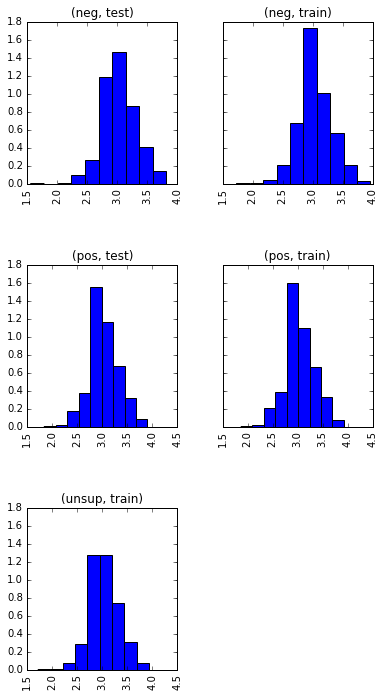

In [21]:
alldatadf[["judgement", "dataset", "review_log_len"]].\
    hist(by = ["judgement", "dataset"], figsize = (6,12),
         sharey=True, normed=True)
pass

## Iterating through a data frame

data frames have property

    df.iterrows() # for rows
    
and

    df.items()    # for columns

you probably will need the former more often. And don't forget about `.apply`

In [22]:
for key, value in alldatadf.iterrows():
    print(key)
    print(value)
    break

0
dataset                                                       train
judgement                                                       pos
internal_id                                                       0
stars                                                             9
review            bromwell high is a cartoon comedy .  it ran at...
review_len                                                      886
review_log_len                                              2.94743
Name: 0, dtype: object


In [23]:
for key, value in alldatadf.iteritems(): # items() for Python3 also works
    print(key)

dataset
judgement
internal_id
stars
review
review_len
review_log_len


## Fit linear regression using `sklearn`

In [24]:
from sklearn import linear_model
X = alldatadf["review_log_len"].as_matrix().reshape(-1, 1)
y = alldatadf["stars"]
mo = linear_model.LinearRegression()
mo.fit(X, y)
print(mo.score(X, y))
print(mo.coef_)

0.000128951115312
[-0.1476958]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


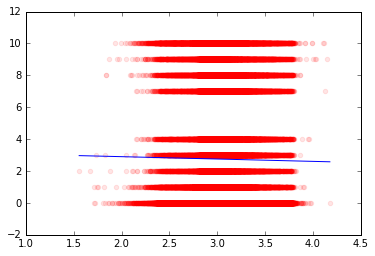

In [25]:
plt.scatter(X,y, color = (1,0,0,.1))
x_ = np.r_[min(X), max(X)]
plt.plot(x_, mo.intercept_ + mo.coef_*x_, "b-")
pass

In [26]:
goodbad = pd.concat([
            alldatadf["review"].map(lambda x : "good" in x),
            alldatadf["review"].map(lambda x : "bad" in x)], 
          keys = ["good", "bad"],
          join="inner",
          axis=1)

goodbad.all(axis=1).sum() / goodbad.shape[0]

0.12714

In [27]:
# alldatadf[["judgement", "dataset", "review_len"]].groupby(["judgement", "dataset"]).hist()

In [28]:
alldatadf["stars"].value_counts().sort_index()

0     50000
1     10122
2      4586
3      4961
4      5331
7      4803
8      5859
9      4607
10     9731
Name: stars, dtype: int64

In [29]:
alldatadf["stars"][alldatadf["judgement"]!="unsup"].value_counts().sort_index()

1     10122
2      4586
3      4961
4      5331
7      4803
8      5859
9      4607
10     9731
Name: stars, dtype: int64

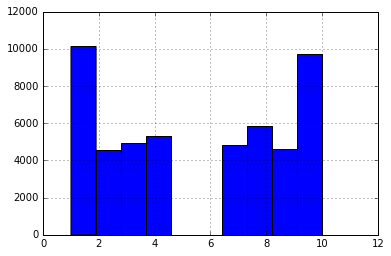

In [30]:
alldatadf["stars"][alldatadf["judgement"]!="unsup"].hist()

In [31]:
alldatadf.groupby(["judgement", "dataset"]).agg("count")

internal_id  stars  review  review_len  review_log_len
judgement dataset                                                        
neg       test           12500  12500   12500       12500           12500
          train          12500  12500   12500       12500           12500
pos       test           12500  12500   12500       12500           12500
          train          12500  12500   12500       12500           12500
unsup     train          50000  50000   50000       50000           50000

In [32]:
alldatadf.groupby(["judgement", "dataset"]).agg(np.mean)["stars"]

judgement  dataset
neg        test       2.22312
           train      2.21696
pos        test       8.80280
           train      8.73848
unsup      train      0.00000
Name: stars, dtype: float64

In [33]:
alldatadf.groupby(["dataset"]).agg(np.mean)["stars"]

dataset
test     5.512960
train    1.825907
Name: stars, dtype: float64

In [34]:
alldatadf[alldatadf["judgement"]!="unsup"].groupby(["dataset"]).agg(np.mean)["stars"]

dataset
test     5.51296
train    5.47772
Name: stars, dtype: float64

In [35]:
"remove unsupervised data points"
alldatadf = alldatadf[(alldatadf["judgement"]!="unsup")]

In [36]:
"replace textual judgement label by a binary/boolean label"
alldatadf["positive_judgement"] = alldatadf["judgement"] == "pos"
alldatadf.drop("judgement", axis=1, inplace=True)

In [37]:
train_data = alldatadf[(alldatadf["dataset"] == "train")].copy()
train_data.drop("dataset", axis=1, inplace=True)
# del alldatadf

## Run simple analysis with `sklearn`

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from nltk.tokenize import TreebankWordTokenizer
from sklearn.utils import shuffle

ngram_size = 3
vectorizer = TfidfVectorizer(ngram_range=(1, ngram_size), min_df = .1, stop_words='english')
# tokenizer=TreebankWordTokenizer().tokenize)

classifier_pipeline = Pipeline([
    ('count_vectorizer',   vectorizer),
    ('classifier',         MultinomialNB()),
])

/Users/dlituiev/repos/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**visualize ngram matrix**

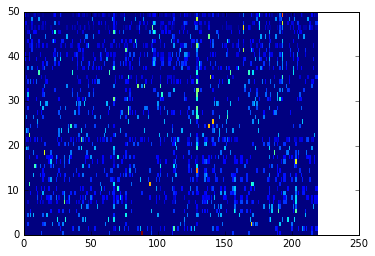

In [39]:
ngrams = vectorizer.fit_transform(train_data[:50].review.as_matrix())
plt.pcolor(np.asarray(ngrams.todense()))
pass

In [40]:
num_points = 1000
X, y = shuffle(train_data["review"], train_data["positive_judgement"])
X, y = X[:num_points], y[:num_points]
X.shape, y.shape

((1000,), (1000,))

In [41]:
"equivalent statement"
num_points = 1000
y = shuffle(train_data["positive_judgement"])[:num_points]#.as_matrix()
X = train_data.loc[y.index.tolist()]["review"].as_matrix()

## Estimate performance of the classifier model

In [42]:
from sklearn import cross_validation
cross_validation.cross_val_score(classifier_pipeline, X, y, cv = 5, scoring="roc_auc")

array([ 0.77049505,  0.75950495,  0.7711    ,  0.84292929,  0.80191919])

In [43]:
cross_validation.cross_val_score(classifier_pipeline, X, y, cv = 5, scoring="accuracy")

array([ 0.67661692,  0.67661692,  0.685     ,  0.77386935,  0.72864322])

## Fit model on the whole data set and inspect the weights

In [44]:
classifier_pipeline.fit(X,y)

Pipeline(steps=[('count_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smoot...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

## confusion matrix

In [45]:
from sklearn import metrics
labels = [True, False]
yhat = classifier_pipeline.predict(X)
confmatr = pd.DataFrame(
    metrics.confusion_matrix(yhat, y, labels=labels),
    index = labels,
    columns = labels
    )
confmatr.index.name = "predicted"
confmatr.columns.name = "observed"
confmatr

observed,True,False
predicted,,
True,373,130
False,125,372


In [46]:
confmatr = pd.DataFrame({"yhat":yhat, 
                         "y": y,
                         "count":1}).groupby(["y", "yhat"]).agg(sum)
confmatr

count
y     yhat        
False False    372
      True     130
True  False    125
      True     373

In [47]:
pd.pivot_table(confmatr.reset_index(), columns="y", index="yhat")

count      
y     False True 
yhat             
False   372   125
True    130   373

In [48]:
"pull out the steps of the pipeline"
cntv = classifier_pipeline.get_params()["count_vectorizer"]
cl = classifier_pipeline.get_params()["classifier"]
model_analysis = pd.DataFrame({"coef": cl.coef_[0]}, index=cntv.get_feature_names()) 
model_analysis[-5:]

,coef
work,-4.594380
world,-4.575541
worst,-6.505632
years,-4.340526
young,-4.278419


In [49]:
model_analysis["voc"] =  [cntv.vocabulary_[kk] for kk in model_analysis.index.tolist()]

In [50]:
ntop = 10
pd.DataFrame({
            "negative": model_analysis["coef"].sort_values()[:ntop].index,
            "positive": model_analysis["coef"].sort_values()[-ntop:].index
             })

,negative,positive
0,worst,best
1,minutes,just
2,thing,time
3,making,love
4,didn,good
5,gets,like
6,looking,great
7,isn,story
8,actually,movie
9,long,film


## Fit an elastic net regression model

$$
\mathrm{loss} = (y - b \cdot x)^2
$$


$$
\mathrm{loss} = (y - b_j \cdot x_j)^2 + \alpha_2 \sum  b_j^2 + \alpha_1 |\sum b_j|
$$

In [76]:
from sklearn.linear_model import ElasticNetCV

In [77]:
regression_pipeline = Pipeline([
    ('count_vectorizer',   vectorizer),
    ('regression',         ElasticNetCV(l1_ratio=0.5)),
])

In [60]:
num_points = 1000
X, y = shuffle(train_data["review"], train_data["stars"])
X, y = X[:num_points], y[:num_points]
X.shape, y.shape

((1000,), (1000,))

In [61]:
cross_validation.cross_val_score(regression_pipeline, X, y, cv = 5, scoring="r2")

array([ 0.07168381,  0.2024775 ,  0.25189567,  0.17294532,  0.20578987])

In [62]:
regression_pipeline.fit(X,y)
yhat = regression_pipeline.predict(X)

(0, 11)

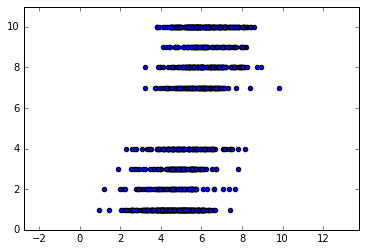

In [73]:
plt.scatter(yhat, y)
plt.axis("equal")
plt.xlim([0,11])
plt.ylim([0,11])

In [57]:
from sklearn import cross_validation
cross_validation.cross_val_score(regression_pipeline, X, y, cv=5, scoring="r2")

array([ 0.20401317,  0.17588378,  0.23349723,  0.29885671,  0.2659625 ])

## Fit a bunch of classifiers and compare their performance
adapted from http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

In [103]:
# split into a training set and a test set
num_points = 1000

xraw_train, y_train = shuffle( alldatadf.set_index("dataset").loc["train"]["review"],
                              alldatadf.set_index("dataset").loc["train"]["positive_judgement"])
xraw_train = xraw_train[:num_points]
y_train = y_train[:num_points]

y_train = alldatadf.set_index("dataset").loc["train"]["positive_judgement"]
y_test = alldatadf.set_index("dataset").loc["test"]["positive_judgement"]

xraw_train = alldatadf.set_index("dataset").loc["train"]["review"]
xraw_test = alldatadf.set_index("dataset").loc["test"]["review"]

Extracting features from the training data using a sparse vectorizer
n_samples: 25000, n_features: 74536

Extracting features from the test data using the same vectorizer
done in 4.751129s at 7.034MB/s
n_samples: 25000, n_features: 74536

Extracting 20 best features by a chi-squared test
done in 0.096809s

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.034s
test time:  0.001s
accuracy:   0.763
dimensionality: 20
density: 1.000000

classification report:
             precision    recall  f1-score   support

      False       0.82      0.67      0.74     12500
       True       0.72      0.86      0.78     12500

avg / total       0.77      0.76      0.76     25000

confusion matrix:
[[ 8361  4139]
 [ 1785 10715]]

Perceptron
___________________

/Users/dlituiev/repos/scikit-learn/sklearn/linear_model/ridge.py:306: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


train time: 0.086s
test time:  0.001s
accuracy:   0.730
dimensionality: 20
density: 1.000000

classification report:
             precision    recall  f1-score   support

      False       0.87      0.54      0.67     12500
       True       0.67      0.92      0.77     12500

avg / total       0.77      0.73      0.72     25000

confusion matrix:
[[ 6742  5758]
 [  996 11504]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
train time: 0.081s
test time:  0.001s
accuracy:   0.765
dimensionality: 20
density: 1.000000

classification report:
             precision    recall  f1-score   support

      False       0.81      0.70      0.75     12500
       True       0.73      0.83      0.78     12500

avg / total       0.77      0.

/Users/dlituiev/repos/scikit-learn/sklearn/svm/classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 0.181s
test time:  0.001s
accuracy:   0.765
dimensionality: 20
density: 1.000000

classification report:
             precision    recall  f1-score   support

      False       0.82      0.68      0.74     12500
       True       0.73      0.85      0.78     12500

avg / total       0.77      0.76      0.76     25000

confusion matrix:
[[ 8478  4022]
 [ 1864 10636]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.140s
test time:  0.000s
accuracy:   0.741
dimensionality: 20
density: 1.000000

classification report:
             precision    recall  f1-score   support

      False       0.87      0.57      0.69     12500
     

/Users/dlituiev/repos/scikit-learn/sklearn/svm/classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 0.101s
test time:  0.001s
accuracy:   0.742
dimensionality: 20
density: 1.000000

classification report:
             precision    recall  f1-score   support

      False       0.87      0.57      0.69     12500
       True       0.68      0.91      0.78     12500

avg / total       0.77      0.74      0.73     25000

confusion matrix:
[[ 7158  5342]
 [ 1110 11390]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.008s
test time:  0.004s
accuracy:   0.753
classification report:
             precision    recall  f1-score   support

      False       0.83      0.63      0.72     12500
       True       0.70      0.87      0.78     12500

avg / total       0.77      0.75      0.75     25000

confusion matrix:
[[ 7931  4569]
 [ 1598 10902]]

Naive Bayes
______________________________________________________________________

/Users/dlituiev/repos/scikit-learn/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/dlituiev/repos/scikit-learn/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


train time: 0.089s
test time:  0.004s
accuracy:   0.765
classification report:
             precision    recall  f1-score   support

      False       0.82      0.68      0.74     12500
       True       0.73      0.85      0.78     12500

avg / total       0.77      0.76      0.76     25000

confusion matrix:
[[ 8478  4022]
 [ 1864 10636]]



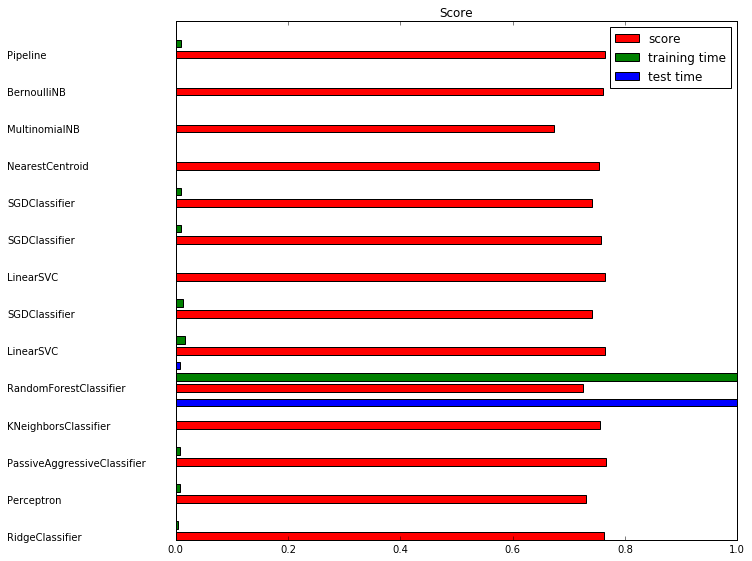

In [105]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


categories = [True, False]
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(xraw_train)
data_test_size_mb = size_mb(xraw_test)

from time import time
print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
use_hashing=False
n_features = 2 ** 16
select_chi2 = 20
print_top10 = False
print_report = True
print_cm = True
if use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', non_negative=True,
                                   n_features=n_features)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    
X_train = vectorizer.fit_transform(xraw_train)
duration = time() - t0
# print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(xraw_test)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


###############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, category in enumerate(clf.classes_):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s"
                      % (category, " ".join(feature_names[top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=["%s" % x for x in clf.classes_]))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()